In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/ECE473_Final_Project/data69.json"
df = pd.read_json(path)
print(df)

         trade_seq      trade_id               timestamp  tick_direction  \
0               10      87628878 2020-08-09 23:33:50.713               3   
1                9      87628877 2020-08-09 23:33:50.713               2   
2                8      87626316 2020-08-09 22:13:25.475               0   
3                7      87625758 2020-08-09 22:02:26.112               3   
4                6      87591530 2020-08-09 10:50:31.649               3   
...            ...           ...                     ...             ...   
1514202          3  ETH-18311978 2020-07-08 22:44:22.377               0   
1514203          2  ETH-18310526 2020-07-08 21:22:10.123               1   
1514204          1  ETH-18298072 2020-07-08 14:35:39.762               1   
1514205          2  ETH-17392554 2020-06-08 14:02:40.239               2   
1514206          1  ETH-17373097 2020-06-07 19:54:34.595               1   

          price  mark_price      iv      instrument_name  index_price  \
0        0.000

In [ ]:
import time
import datetime
print(len(df['instrument_name']))
dates = []
for string in df['instrument_name']:
  date_str = string.split('-')[1]  # Get the date string from the data

  # Convert the date string to epoch time
  date_time = time.strptime(date_str, '%d%b%y')
  epoch_time = int(time.mktime(date_time))
  dates.append(epoch_time)
df['expiry_time'] = dates
df['expiry_time']=(pd.to_datetime(df['expiry_time'],unit='s'))

1514207


In [ ]:
df['time_until_expiry'] = df['expiry_time'] - df['timestamp']

In [ ]:
strikes = []
types = []
underlyings = []
for string in df['instrument_name']:
  strike = int(string.split('-')[2])
  type_str = string.split('-')[3]
  underlying_str = string.split('-')[0]
  strikes.append(strike)
  types.append(type_str)
  underlyings.append(underlying_str)
df['strike'] = strikes
df['type'] = types
df['underlying'] = underlyings

In [ ]:
print(df)

         trade_seq      trade_id               timestamp  tick_direction  \
0               10      87628878 2020-08-09 23:33:50.713               3   
1                9      87628877 2020-08-09 23:33:50.713               2   
2                8      87626316 2020-08-09 22:13:25.475               0   
3                7      87625758 2020-08-09 22:02:26.112               3   
4                6      87591530 2020-08-09 10:50:31.649               3   
...            ...           ...                     ...             ...   
1514202          3  ETH-18311978 2020-07-08 22:44:22.377               0   
1514203          2  ETH-18310526 2020-07-08 21:22:10.123               1   
1514204          1  ETH-18298072 2020-07-08 14:35:39.762               1   
1514205          2  ETH-17392554 2020-06-08 14:02:40.239               2   
1514206          1  ETH-17373097 2020-06-07 19:54:34.595               1   

          price  mark_price      iv      instrument_name  index_price  \
0        0.000

In [ ]:
df['days_until_expiry'] = df['time_until_expiry'].dt.days
df['trade_day'] = df['timestamp'].dt.date

In [ ]:
print(df['trade_day'][0].day == datetime.datetime(2020, 5, 8, 0, 0).day)

False


In [ ]:
are_btc = df['underlying'] == 'BTC'
are_eth = df['underlying'] == 'ETH'
df_btc = df[are_btc]
df_eth = df[are_eth]

In [ ]:
print(df_btc)

         trade_seq  trade_id               timestamp  tick_direction   price  \
0               10  87628878 2020-08-09 23:33:50.713               3  0.0005   
1                9  87628877 2020-08-09 23:33:50.713               2  0.0005   
2                8  87626316 2020-08-09 22:13:25.475               0  0.0010   
3                7  87625758 2020-08-09 22:02:26.112               3  0.0005   
4                6  87591530 2020-08-09 10:50:31.649               3  0.0005   
...            ...       ...                     ...             ...     ...   
1208622          5  81623283 2020-06-07 13:56:34.398               1  0.0020   
1208623          4  81613542 2020-06-07 13:16:46.775               0  0.0020   
1208624          3  81608740 2020-06-07 12:52:46.091               1  0.0015   
1208625          2  81599398 2020-06-07 12:13:19.349               1  0.0015   
1208626          1  81589711 2020-06-07 10:27:50.175               1  0.0015   

         mark_price     iv      instrum

In [ ]:
print(df_btc['days_until_expiry'])

0          0
1          0
2          0
3          0
4          0
          ..
1208622    1
1208623    1
1208624    1
1208625    1
1208626    1
Name: days_until_expiry, Length: 1207351, dtype: int64


In [ ]:
# returns option price in dollars (USES 'MARK PRICE', NOT 'PRICE')
#current_time is a datetime.datetime object
def find_option_price(current_time, target_days_until_expiry, target_strike, option_type, underlying):
  if(underlying == 'BTC'):
    are_date_matches = df_btc['timestamp'].dt.day == current_time.day
    are_expiry_matches = df_btc['days_until_expiry'] == target_days_until_expiry
    are_type_matches = df_btc['type'] == option_type
    are_type_date_expiry_matches = are_date_matches & are_expiry_matches & are_type_matches
    type_date_expiry_matches = df_btc[are_type_date_expiry_matches]
    closest_option_index = pd.Series.idxmin((type_date_expiry_matches['strike'] - target_strike).abs())
    best_strike = type_date_expiry_matches['strike'][closest_option_index]
    are_strike_matches = type_date_expiry_matches['strike'] == best_strike
    option_matches = type_date_expiry_matches[are_strike_matches]
    return (option_matches['mark_price'].mul(option_matches['index_price'])).mean(), best_strike
    #option_matches['dollar_prices'] = option_matches['mark_price'].mul(option_matches['index_price'])
    #return type_date_expiry_matches['mark_price'][closest_option_index] * type_date_expiry_matches['index_price'][closest_option_index]
    #return option_matches['dollar_prices'].mean()
  elif(underlying == 'ETH'):
    are_date_matches = df_eth['timestamp'].dt.day == current_time.day
    are_expiry_matches = df_eth['days_until_expiry'] == target_days_until_expiry
    are_type_matches = df_eth['type'] == option_type
    are_type_date_expiry_matches = are_date_matches & are_expiry_matches & are_type_matches
    type_date_expiry_matches = df_eth[are_type_date_expiry_matches]
    closest_option_index = pd.Series.idxmin((type_date_expiry_matches['strike'] - target_strike).abs())
    return type_date_expiry_matches['mark_price'][closest_option_index] * type_date_expiry_matches['index_price'][closest_option_index]
  else: return None





In [ ]:
ret = find_option_price(datetime.datetime(2020, 6, 9, 0, 0), 7, 8750, 'C','BTC')
print(ret)

41.92680617720001


In [ ]:
# return btc market close price on a given date (using datetime.datetime object)
import requests
def eod_btc_price_coingecko(datetime_obj):
  url = 'https://api.coingecko.com/api/v3/coins/bitcoin/history'
  params = {
      'date': datetime_obj.strftime("%m-%d-%Y")
  }

  response = requests.get(url, params=params)
  print(response.json())
  data = response.json()['market_data']
  btc_market_end = data['current_price']['usd']
  return btc_market_end

In [ ]:
import numpy as np
btc_prices = pd.read_csv("/content/drive/MyDrive/ECE473_Final_Project/bitcoin_historical_2019_2020_prices_fixed.csv")
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])
btc_prices['price_returns'] = np.log(btc_prices['Price']) - np.log(btc_prices['Price'].shift(1))
print(btc_prices)

          Date    Price     Open     High      Low     Vol. Change %  \
0   2019-01-01   3809.4   3709.5   3814.3   3664.4  469.11K    2.69%   
1   2019-01-02   3873.8   3809.7   3894.8   3768.1  554.47K    1.69%   
2   2019-01-03   3780.1   3874.1   3875.8   3753.0  450.32K   -2.42%   
3   2019-01-04   3802.7   3780.5   3823.9   3720.0  488.70K    0.60%   
4   2019-01-05   3785.4   3802.8   3846.7   3769.0  468.45K   -0.46%   
..         ...      ...      ...      ...      ...      ...      ...   
726 2020-12-27  26261.3  26460.3  28360.3  25858.2  231.23K   -0.73%   
727 2020-12-28  27057.8  26259.2  27444.9  26144.3  126.98K    3.03%   
728 2020-12-29  27376.0  27065.3  27390.7  25902.8  119.57K    1.18%   
729 2020-12-30  28868.7  27374.5  28979.3  27374.5  159.82K    5.45%   
730 2020-12-31  28949.4  28866.8  29298.8  28025.0  136.69K    0.28%   

     price_returns  
0              NaN  
1         0.016764  
2        -0.024485  
3         0.005961  
4        -0.004560  
..       

In [ ]:
print(btc_prices['Date'][0])

2019-01-01 00:00:00


In [ ]:
def btc_price(datetime_obj): # uses 'price' price
  index_match = (btc_prices['Date'] == datetime_obj)
  return float((btc_prices[index_match]['Price']).to_numpy()[0])


In [ ]:
a = datetime.datetime.fromtimestamp(1546560000)
numFridays = 100
dateList = []
for x in range (0, numFridays):
    dateList.append(a + datetime.timedelta(days = 7*x))
print(dateList)

[datetime.datetime(2019, 1, 4, 0, 0), datetime.datetime(2019, 1, 11, 0, 0), datetime.datetime(2019, 1, 18, 0, 0), datetime.datetime(2019, 1, 25, 0, 0), datetime.datetime(2019, 2, 1, 0, 0), datetime.datetime(2019, 2, 8, 0, 0), datetime.datetime(2019, 2, 15, 0, 0), datetime.datetime(2019, 2, 22, 0, 0), datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 3, 8, 0, 0), datetime.datetime(2019, 3, 15, 0, 0), datetime.datetime(2019, 3, 22, 0, 0), datetime.datetime(2019, 3, 29, 0, 0), datetime.datetime(2019, 4, 5, 0, 0), datetime.datetime(2019, 4, 12, 0, 0), datetime.datetime(2019, 4, 19, 0, 0), datetime.datetime(2019, 4, 26, 0, 0), datetime.datetime(2019, 5, 3, 0, 0), datetime.datetime(2019, 5, 10, 0, 0), datetime.datetime(2019, 5, 17, 0, 0), datetime.datetime(2019, 5, 24, 0, 0), datetime.datetime(2019, 5, 31, 0, 0), datetime.datetime(2019, 6, 7, 0, 0), datetime.datetime(2019, 6, 14, 0, 0), datetime.datetime(2019, 6, 21, 0, 0), datetime.datetime(2019, 6, 28, 0, 0), datetime.datetime(2

In [ ]:
import numpy as np
import math
target_days_until_expiry = 7
strangle_percentage = 40
strikes_strategy = [1 - strangle_percentage/100, 1 + strangle_percentage/100]
types_strategy =   [ 'P',  'C']
underlying = 'BTC'
strategy_costs = np.zeros(len(dateList))
underlying_prices = np.zeros(len(dateList))
option_exits = np.zeros(len(dateList))
IL = np.zeros(len(dateList))
IL_rates = np.zeros(len(dateList))
profits = np.zeros(len(dateList))
for i in range(0,len(dateList)):
  curr_price = btc_price(dateList[i])
  exit_price = btc_price(dateList[i] + datetime.timedelta(days = target_days_until_expiry))
  strategy_cost = 0
  option_exit = 0
  for j in range(len(strikes_strategy)):
    cost, best_strike = find_option_price(dateList[i], target_days_until_expiry, 
                                       curr_price*strikes_strategy[j], types_strategy[j], underlying)
    strategy_cost += cost
    if(types_strategy[j] == 'C'):
      option_exit += max(exit_price - best_strike, 0)
    else:
      option_exit += max(best_strike - exit_price, 0)
  K = exit_price / curr_price
  IL_rate = ((2 * math.sqrt(K)) / (1+K)) - 1
  IL_rates[i] = IL_rate
  total_value = (1*exit_price + curr_price)
  IL[i] = total_value * IL_rate
  option_exits[i] = option_exit
  strategy_costs[i] = strategy_cost
  underlying_prices[i] = curr_price
  profits[i] = option_exits[i] - strategy_costs[i] - IL[i]

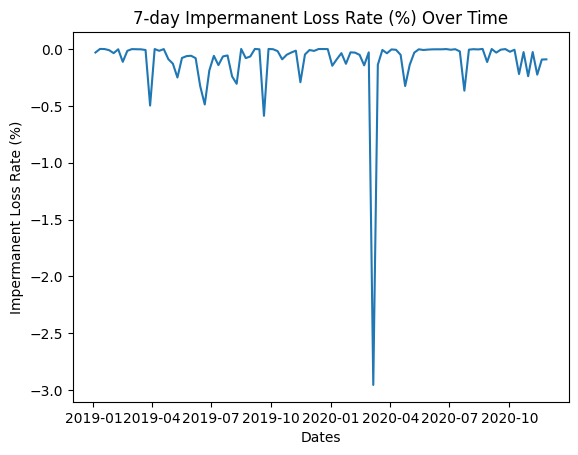

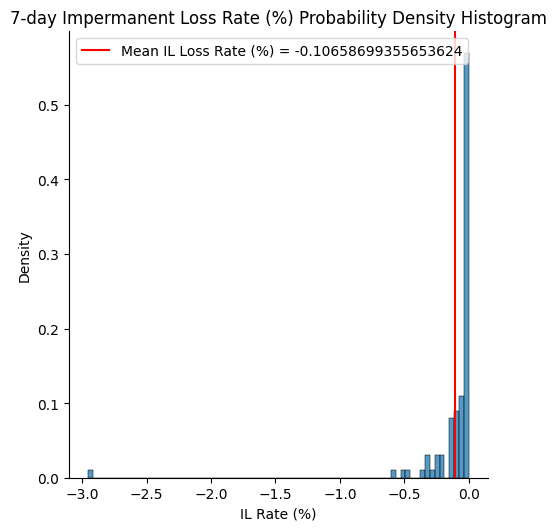

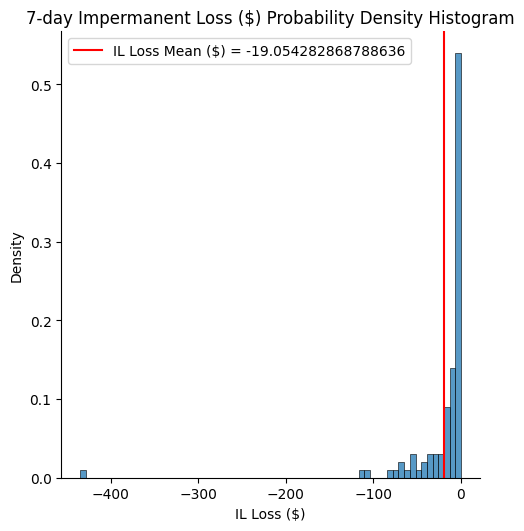

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("7-day Impermanent Loss Rate (%) Over Time")
plt.ylabel("Impermanent Loss Rate (%)")
plt.xlabel("Dates")
plt.plot(dateList, IL_rates*100)
plt.show()

#plt.title("7-day Impermanent Loss Rate (%) Probability Density Histogram")
sns.displot(data = IL_rates*100, kind='hist', stat='probability').set(title="7-day Impermanent Loss Rate (%) Probability Density Histogram", 
                                                                      xlabel="IL Rate (%)", ylabel="Density")
temp = IL_rates*100
plt.axvline(x = temp.mean(), label = "Mean IL Loss Rate (%) = " + str(temp.mean()), color = 'red')
plt.legend(loc = "upper left")
plt.show()
sns.displot(data = IL, kind='hist', stat='probability').set(title="7-day Impermanent Loss ($) Probability Density Histogram", 
                                                                      xlabel="IL Loss ($)", ylabel="Density")
plt.axvline(x = IL.mean(), label = "IL Loss Mean ($) = " + str(IL.mean()), color = 'red')
plt.legend(loc = "upper left")


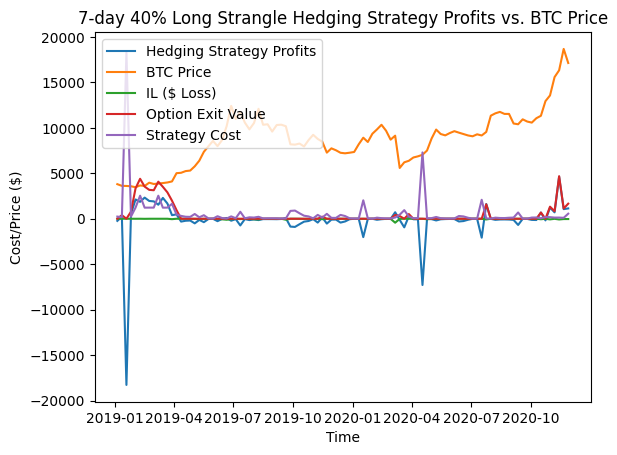

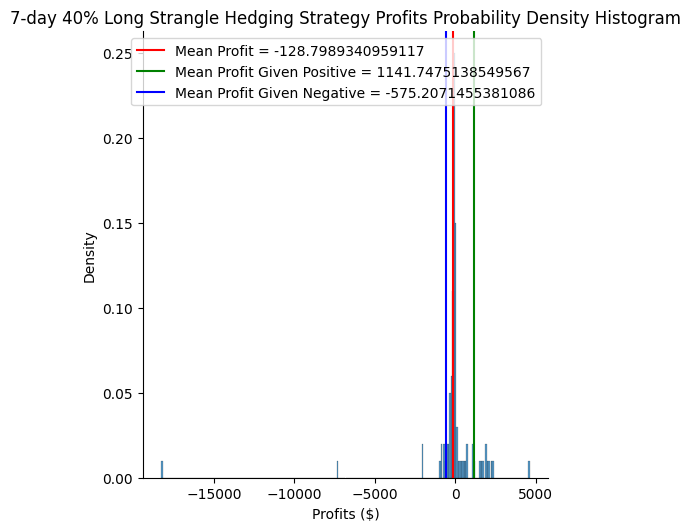

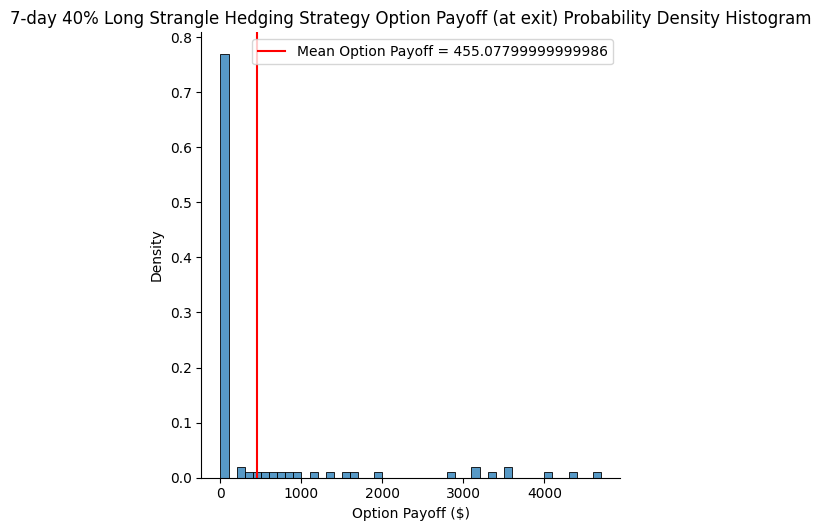

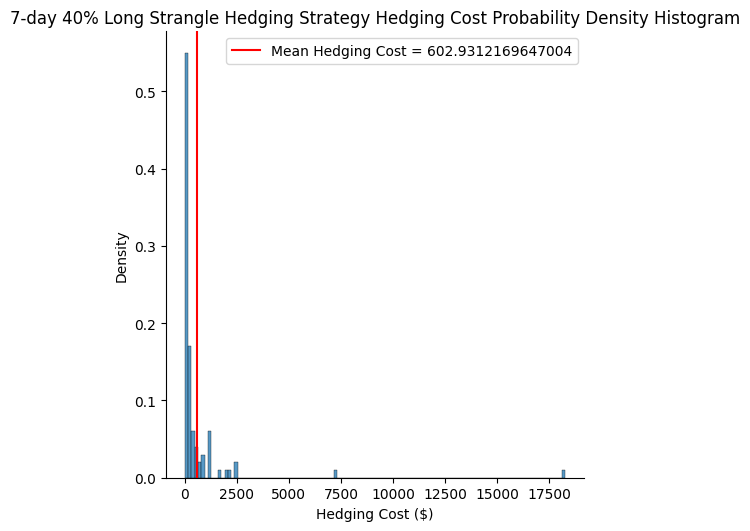

In [ ]:
plt.plot(dateList, profits, label="Hedging Strategy Profits")
plt.plot(dateList, underlying_prices, label = "BTC Price")
plt.plot(dateList, IL, label="IL ($ Loss)")
plt.plot(dateList, option_exits, label = "Option Exit Value")
plt.plot(dateList, strategy_costs, label = "Strategy Cost")
plt.title(str(target_days_until_expiry) + "-day " + str(strangle_percentage) + "% Long Strangle Hedging Strategy Profits vs. BTC Price")
plt.xlabel("Time")
plt.ylabel("Cost/Price ($)")
plt.legend(loc="upper left")
plt.show()


#profits
sns.displot(data = profits, kind='hist', stat='probability').set(title=str(target_days_until_expiry) + 
                                                                      "-day " + str(strangle_percentage) + "% Long Strangle Hedging Strategy Profits Probability Density Histogram",
                                                                 xlabel="Profits ($)", ylabel="Density")
plt.axvline(x=profits.mean(),
            color='red', label = 'Mean Profit = '+ str(profits.mean()))
plt.axvline(x=profits[profits >= 0].mean(),
            color='green', label = 'Mean Profit Given Positive = '+ str(profits[profits >= 0].mean()))
plt.axvline(x=profits[profits < 0].mean(),
            color='blue', label = 'Mean Profit Given Negative = '+ str(profits[profits < 0].mean()))
plt.legend(loc = "upper right")
#option payoff
sns.displot(data = option_exits, kind='hist', stat='probability', binwidth = 100).set(title=str(target_days_until_expiry) + 
                                                                      "-day " + str(strangle_percentage) + "% Long Strangle Hedging Strategy Option Payoff (at exit) Probability Density Histogram",
                                                                 xlabel="Option Payoff ($)", ylabel="Density")
plt.axvline(x=option_exits.mean(),
            color='red', label = 'Mean Option Payoff = ' + str(option_exits.mean()))
plt.legend(loc = "upper right")
#hedging cost

sns.displot(data = strategy_costs, kind='hist', stat='probability').set(title=str(target_days_until_expiry) + 
                                                                      "-day " + str(strangle_percentage) + "% Long Strangle Hedging Strategy Hedging Cost Probability Density Histogram",
                                                                 xlabel="Hedging Cost ($)", ylabel="Density")
plt.axvline(x=strategy_costs.mean(),
            color='red', label = 'Mean Hedging Cost = ' + str(strategy_costs.mean()))
plt.legend(loc = "upper right")


In [ ]:
print(profits.mean())
print(profits[profits>0].mean())
print(sum(profits > 0) / len(profits))
print(profits[profits<=0].mean())
print(sum(profits <= 0) / len(profits))
print("cumulative profits = " + str(sum(profits)))

-128.7989340959117
1141.7475138549567
0.26
-575.2071455381086
0.74
cumulative profits = -12879.893409591179


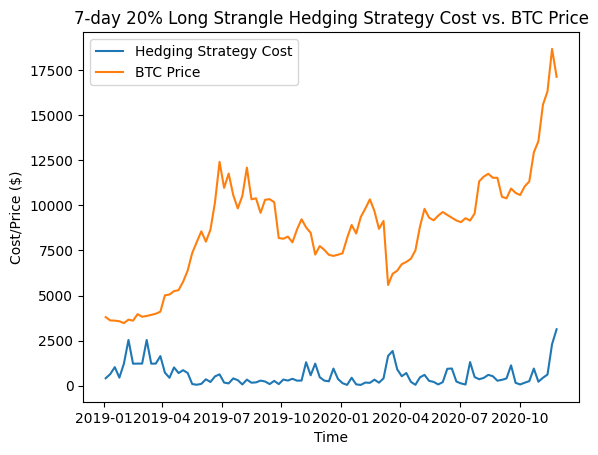

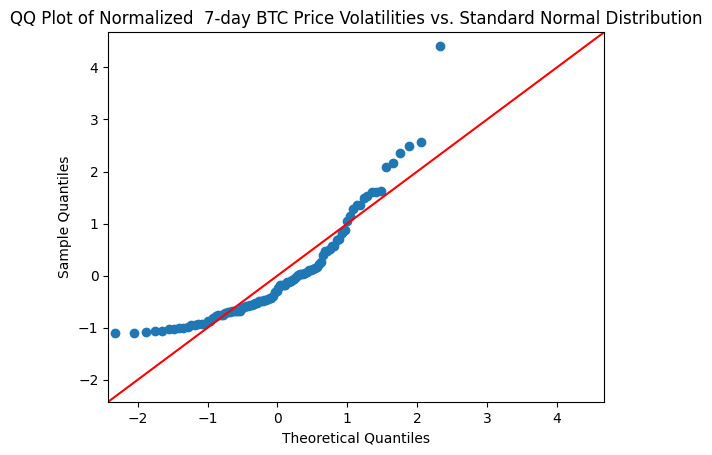

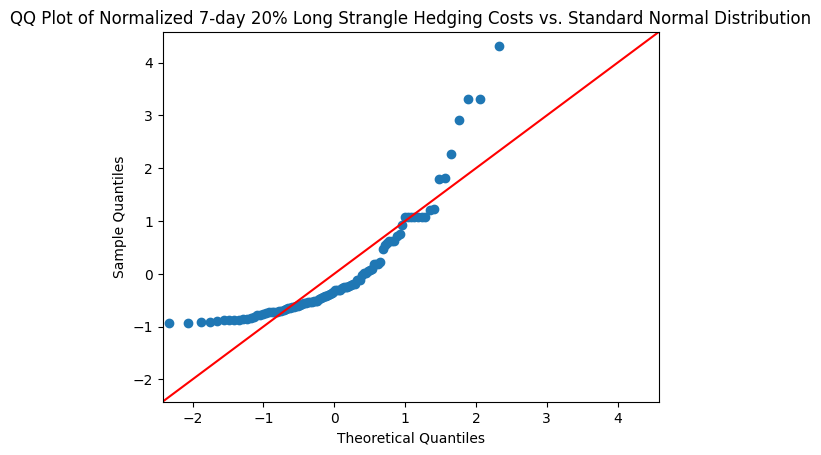

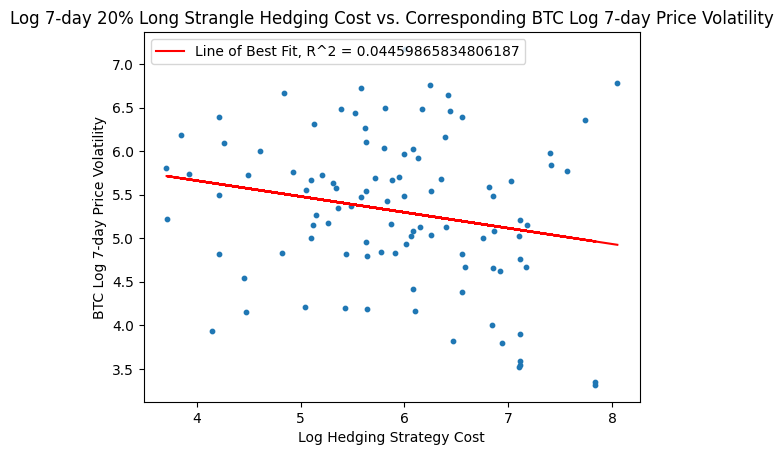

score = 0.04459865834806187
coef = [-0.18206994]
intercept = 6.3896911304875985


In [ ]:
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math


plt.plot(dateList, strategy_costs, label="Hedging Strategy Cost")
plt.plot(dateList, underlying_prices, label = "BTC Price")
plt.title(str(target_days_until_expiry) + "-day " + str(strangle_percentage) + "% Long Strangle Hedging Strategy Cost vs. BTC Price")
plt.xlabel("Time")
plt.ylabel("Cost/Price ($)")
plt.legend(loc="upper left")
plt.show()

vols = []
for i in range(len(dateList)):
  index_match =btc_prices.index[btc_prices['Date'] == dateList[i]].tolist()[0]
  temp_prices = btc_prices['Price'][index_match:index_match + target_days_until_expiry].to_numpy()
  vols.append(math.sqrt(np.var(temp_prices)))
vols = np.array(vols)
normed_vols = (vols - np.mean(vols)) / (vols.std())

import statsmodels.api as sm
import pylab as py
sm.qqplot(normed_vols, line ='45')
py.title("QQ Plot of Normalized  "+ str(target_days_until_expiry) + "-day BTC Price Volatilities vs. Standard Normal Distribution")
py.show()

"""
Since the QQ plot demonstrates that the volatility distribution is not normal, we take the 
log of the volatilities for all subsequetnt statitiscal analysis
"""
normed_strategy_costs = (strategy_costs - np.mean(strategy_costs)) / (strategy_costs.std())
sm.qqplot(normed_strategy_costs, line ='45')
py.title("QQ Plot of Normalized "+ str(target_days_until_expiry) + "-day " + str(strangle_percentage) + "% Long Strangle Hedging Costs vs. Standard Normal Distribution")
py.show()

"""
Since the QQ plot demonstrates that the strategy cost distribution is not normal, we take the 
log of the strategy costs for all subsequetnt statitiscal analysis
"""

log_vols = np.log(vols)
log_strategy_costs = np.log(strategy_costs)
plt.scatter(log_strategy_costs, log_vols, s = 10)
plt.title("Log " + str(target_days_until_expiry) + "-day " + str(strangle_percentage) + "% Long Strangle Hedging Cost vs. Corresponding BTC Log "+ str(target_days_until_expiry) + "-day Price Volatility")
plt.xlabel("Log Hedging Strategy Cost")
plt.ylabel("BTC Log "+ str(target_days_until_expiry) + "-day Price Volatility")
#plt.ylim([-0.01, 0.01])
regr = LinearRegression()
regr.fit(log_strategy_costs.reshape(-1, 1), log_vols)
y_pred = regr.predict(log_strategy_costs.reshape(-1, 1))
plt.plot(log_strategy_costs.reshape(-1, 1), y_pred, color = "red", label = "Line of Best Fit, R^2 = " + str(r2_score(log_vols, y_pred)))
plt.legend(loc = "upper left")
plt.show()
#print("score = " + str(r2_score(log_strategy_costs.reshape(-1, 1), log_vols)))
print("score = " + str(r2_score(log_vols, y_pred)))
print("coef = " + str(regr.coef_))
print("intercept = " + str(regr.intercept_))
coefs = []
coefs.append(regr.coef_[0])


In [ ]:
""